# Décomposition en règles - Partie 4

In [1]:
# Il est nécessaire d'ajouter le chemin du projet au python path,
# pour pouvoir utiliser les ressources mises à disposition.

########## A vous de jouer
# Modifiez le path de manière à ce qu'il corresponde à votre ordinateur.
import sys
sys.path.append('/Users/jms/prod/20181003_Technical_training_interpretability')

## 1. Import du modèle et des données

In [2]:
import pickle

with open('data_model_rf.pickle', 'rb') as handle:
    data_model_dict = pickle.load(handle)

X_train, X_test, y_train, y_test, model = data_model_dict.values()
f_predict = lambda x: model.predict_proba(x)[:,1]

/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/prod/20181003_Technical_training_interpretability/.venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
## Exemple : Une prédiction pour 10 échantillons aléatoires du jeu de test:
f_predict(
    X_test.sample(10, random_state=42)
)

array([0.33058554, 0.54339778, 0.25560691, 0.54657462, 0.0544803 ,
       0.77699009, 0.78250217, 0.31317756, 0.59730188, 0.76966065])

## 2. Entraînement de skope-rules

In [4]:
%%time
# Import skope-rules
from skrules import SkopeRules


skope_rules_clf = SkopeRules(feature_names=X_train.columns, random_state=42, n_estimators=50,
                               recall_min=0.05, precision_min=0.9,
                               max_samples=0.5,
                               max_depth_duplication= 2, max_depth = 3)

skope_rules_clf.fit(X_train, y_train)

CPU times: user 2.94 s, sys: 19.1 ms, total: 2.96 s
Wall time: 2.97 s


In [5]:
skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)
random_forest_scoring = f_predict(X_test)

## 3. Extraction de règles

In [6]:
# Get number of rules created
print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' +
      'SkopeRules.\n')

# Print the rules

for i_rule, rule in enumerate(skope_rules_clf.rules_[:10]):
    print(rule[0]+'\n')

3 rules have been built with SkopeRules.

CANAL_COM__inconnu <= 0.5 and DUREE_CONTACT > 10.149999618530273

DUREE_CONTACT > 13.25

DUREE_CONTACT <= 10.149999618530273 and DUREE_CONTACT > 1.899999976158142 and RESULTAT_PRECEDENT__succès > 0.5



In [7]:
import numpy as np
import pandas as pd
def compute_y_pred_from_query(X, rule):
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[list(X.query(rule).index)] = 1
    return(score)

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return(df)

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return(performances)


print('Precision = 0.96 means that 96% of rows described by the rule belongs to class 1.')
print('Recall = 0.12 means that the rows with class 1 identified by the rule are 12% of the total rows with class 1.\n')

for i in range(3):
    print('Rule '+str(i+1)+':')
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0])
           )

Precision = 0.96 means that 96% of rows described by the rule belongs to class 1.
Recall = 0.12 means that the rows with class 1 identified by the rule are 12% of the total rows with class 1.

Rule 1:


,precision,recall
train_set,0.888446,0.291503
test_set,0.860759,0.269841


Rule 2:


,precision,recall
train_set,0.897059,0.239216
test_set,0.920000,0.212963


Rule 3:


,precision,recall
train_set,0.926829,0.149020
test_set,0.875969,0.149471


## 4. Analyse de performances

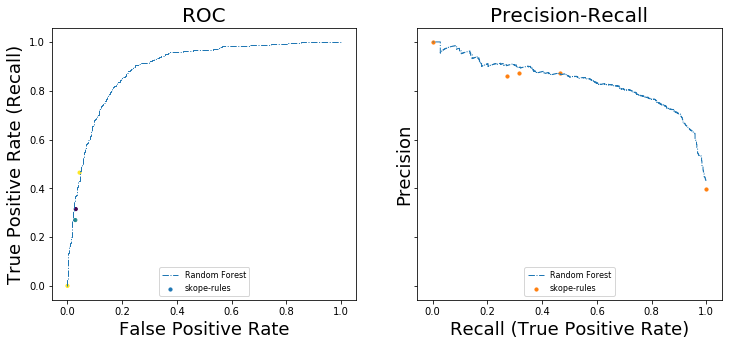

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import cm

def plot_scores(y_true, scores_with_line=[], scores_with_points=[],
                        labels_with_line=['Random Forest'],
                        labels_with_points=['skope-rules']):
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[i_score], lw=1, label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.scatter(fpr[:-1], tpr[:-1], c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.step(recall, precision, linestyle='-.', c=color_list[i_score], lw=1, where='post', label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.scatter(recall, precision, c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("Precision-Recall", fontsize=20)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()
    
plot_scores(y_test,
                    scores_with_line=[random_forest_scoring],
                    scores_with_points=[skope_rules_scoring]
                   )

In [9]:
n_rule_chosen = 3
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('The performances reached with '+str(n_rule_chosen)+' discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 3 discovered rules are the following:


,precision,recall
test_set,0.873134,0.464286
